### Neural Style Transfer

Le neural style transfert est un type d'algorithme de Deep Learning qui permet la création d'images artistiques.
Concrétement nous partons de trois images:
* une image d'entrée
* un content-image
* un style-image

L'algorithme va essayer changer l'image d'entrée avec le contenu du content image, le style du style image.


Nous avons donc deux distances à minimiser:
* $D_c$: le content distance qui mesure la différence entre le contenu du ***content-image*** et celui de l'image d'entrée
* $D_s$: le style distance qui mesure la différence entre le style du ***style-image*** et celui de l'image d'entrée.

Vous trouverez le papier https://arxiv.org/pdf/1508.06576.pdf.



In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as models


from PIL import Image


import os

In [2]:

#télécharge le style image s'il n'existe pas déjà
if 'starrynight.jpg' not in os.listdir():
    !wget https://oceanmhs.org/wp-content/uploads/2018/01/starrynight.jpg
    

In [3]:
#Je resize et standardise mes images
transform=transforms.Compose([transforms.Resize((128,128)),
                             transforms.ToTensor(),
                             transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                             ])


def load_image(pth):
    '''
    pth: le chemin de l'image
    '''
    image=Image.open(pth)
    return transform(image).unsqueeze(0)  #ajoute une dimension batch size


content_image=load_image('dancing.jpg')
style_image=load_image('starrynight.jpg')


#le content image et le style image doivent avoir la même taille 
assert content_image.size()==style_image.size() 

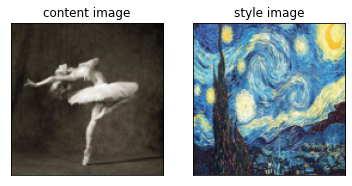

In [4]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]


unnormalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],   #Pour mieux voir les images avec matplotlib
   std= [1/s for s in std])


def imshow(img,title=None):
    '''
    Cette fonction sert à visualiser les images
    
    '''
    img=unnormalize(img).squeeze(0)
    npimg = img.detach().numpy()
    npimg=npimg.clip(0,1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([]), plt.yticks([])
    if title!=None:
        plt.title(title)

        
        
        
plt.subplot(1,2,1)    
imshow(content_image, title='content image')  


plt.subplot(1,2,2)   
imshow(style_image, title='style image')

Pour faire le neural style transfert, nous allons utiliser un modèle déjà entraîné. On utilise ici VGG19 (https://arxiv.org/pdf/1409.1556.pdf) qui est utilisé dans le papier. 

Nous n'utilisons que les couches de convolution et pooling qui sont dans ***.features*** de notre modèle.

Nous n'avons également pas besoin de tracker le gradient.

In [5]:
modelVGG=models.vgg19(pretrained=True).features


for param in modelVGG.parameters(): #pas besoin du gradient
    param.requires_grad=False

In [6]:
print(modelVGG)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Les features maps obtenus après une couche de convolution sont une bonne représentation du contenu de l'image, pour avoir le style nous allons calculer le gramian matrix (https://en.wikipedia.org/wiki/Gramian_matrix) entre les features, cela donne une représentation de la texture (https://fr.wikipedia.org/wiki/Texture_(traitement_des_images).


Nous calculons dans un premier temps:

1.  les features du content image (nous choisissons une couche qui va représenter notre content)
2. le style image pour chaque couche de convolution à l'aide du gramian matrix (comme proposé dans le papier).


Nous prenons ensuite l'image d'entrée qu'on va entrainer sur le modèle, nous utilisons l'optimiseur ADAM pour mettre à jour ses valeurs, le mseLoss est utilisé, dans le but qu'il matche le contenu du content-image et le style du style-image.


In [7]:
def get_features(model,image,layers):
    '''Cette fonction permet d'obtenir les features d'une image de certaines couches d'un model
    inputs:
        model: le modèle entrainé
        image: l'image sur laquelle nous voulons les features
        layers: (list) les couches
        
    outputs:
        features: les features
    
    '''
    features={}
    x=image;i=1
    for layer in range(len(model)):
        x=model[layer](x)
        if layer in layers:
            features['Conv_'+str(i)]=x  
            i+=1
    return features    
    

    

In [8]:
def gram_matrix(input):
    '''
    cette fonction prend en entrée une image et calcule le gramian matrix normalisé
    
    '''
    a,b,c,d=input.size()
    features=input.view(a*b,c*d)
    return torch.mm(features,features.t()).div(a*b*c*d)


layers=[0,5,10,19,28]  #Les couches de convolution utilisées
content_features=get_features(modelVGG,content_image,layers=layers)


style_features=get_features(modelVGG,style_image,layers=layers)
style_gram={k:gram_matrix(style_features[k]) for k in style_features.keys()}

Pour chaque couche de convolution nous lui donnons un poids $w_l$=1/4 où 1/4 représente ici le nombre de couches de convolutions actives pour le style.

Nous avons également le content_weight le poids du content loss, et le style_weight le poids su style content.


$$Loss_{total}=\alpha*content\_loss+ \beta * style\_loss$$

***Note***: le Conv_4 est choisi ici pour avoir le contenu.

In [9]:
style_weights = {'Conv_1': 1/4,
                 'Conv_2': 1/4,
                 'Conv_3': 1/4,
                 'Conv_5': 1/4}



content_weight = 1  # alpha
style_weight = 1e9  # beta


Loss: 6270.583984375


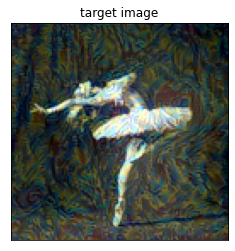

Loss: 3516.544677734375


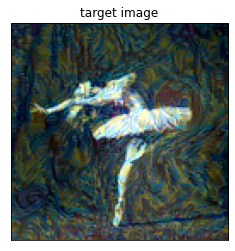

Loss: 2347.17529296875


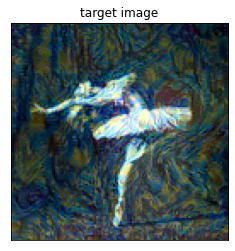

In [10]:
target=content_image.clone().requires_grad_(True)  #Nou partons de l'image content



optimizer=torch.optim.Adam([target],lr=0.003)
epochs=2000

for i in range(1,epochs):
    target_feature=get_features(modelVGG,target,layers) #récupère les features 
    content_loss=F.mse_loss(content_features['Conv_4'],target_feature['Conv_4'])  #calcule la différence entre le content feature et le target feature
    
    
    style_loss=0
    
    #Pour chaque couche, nous calculons le style representation
    for layer in style_weights:
        target_feat=target_feature[layer]
        target_gram=gram_matrix(target_feat)
        
        
        layer_style_loss=style_weights[layer]*F.mse_loss(target_gram,style_gram[layer])
        style_loss+=layer_style_loss
        
    total_loss=content_weight*content_loss+style_weight*style_loss
    
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    
    
    if i%500==0:
        print(f'Loss: {total_loss.item()}')
        imshow(target, title='target image') 
        plt.show()
        
    
    
        
    

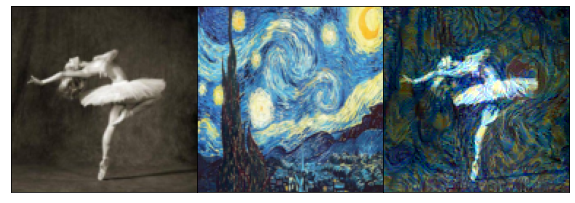

In [27]:
plt.figure(figsize=(10,10))

plt.subplot(1,3,1)    
imshow(content_image)  

plt.subplot(1,3,2)    
imshow(style_image)  

plt.subplot(1,3,3)   
imshow(target)


plt.subplots_adjust(hspace=0,wspace=0)
plt.savefig('images.jpg',bbox_inches='tight')

Cheikh TOURE